# Stochastic Particle Simulation

In [63]:
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import numpy as np
import io
import imageio.v2 as imageio
import base64
from IPython.display import HTML, display
import uuid
import copy

In [71]:
def initialize_particles(n_particles_per_species, env_size, diffusion_rates, advection_rates=None):
    """
    Initialize particle positions for multiple species.
    
    Parameters:
    - n_particles_per_species: List of numbers of particles for each species.
    - env_size: Tuple indicating the xlim and ylim of the environment, as ((xmin, xmax), (ymin, ymax)).
    - diffusion_rates: List of diffusion rates for each species.
    - advection_rates: List of advection vectors for each species.
    
    Returns:
    - particles: List of dictionaries representing particles.
    """
    advection_rates = advection_rates or [(0.0,0.0) for s in range(len(n_particles_per_species))]
    particles = []
    species_colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Extend as needed
    
    for species_idx, n_particles in enumerate(n_particles_per_species):
        color = species_colors[species_idx % len(species_colors)]
        diffusion_rate = diffusion_rates[species_idx]
        advection_rate = advection_rates[species_idx]
        
        for _ in range(n_particles):
            particle = {
                'id': str(uuid.uuid4()),
                'position': np.random.uniform(low=[env_size[0][0], env_size[1][0]], 
                                              high=[env_size[0][1], env_size[1][1]], 
                                              size=2),
                'size': np.random.uniform(10, 100),
                'color': color,
                'diffusion_rate': diffusion_rate,
                'advection': advection_rate
            }
            particles.append(particle)
    
    return particles

def simulate_particles(particles, total_time, env_size):
    """
    Simulate particle movements for each species.
    
    Parameters:
    - particles: List of dictionaries representing particles.
    - total_time: Total time (frames) of the simulation.
    - env_size: Tuple indicating the xlim and ylim of the environment, as ((xmin, xmax), (ymin, ymax)).
    
    Returns:
    - history: History of particles at each time step.
    """
    history = [copy.deepcopy(particles)]  # Initialize history with initial particles
    
    for frame in range(total_time):
        for particle in particles:
            # Apply diffusion and advection
            dx, dy = np.random.normal(0, particle['diffusion_rate'], 2) + particle['advection']
            
            new_x_position = particle['position'][0] + dx
            new_y_position = particle['position'][1] + dy
            
            # enforce boundary
            if new_x_position < env_size[0][0]:
                new_x_position = env_size[0][0]
            elif new_x_position > env_size[0][1]:
                new_x_position = env_size[0][1]
                
            if new_y_position < env_size[1][0]:
                new_y_position = env_size[1][0]
            elif new_y_position > env_size[1][1]:
                new_y_position = env_size[1][1]
            
            particle['position'][0] = new_x_position
            particle['position'][1] = new_y_position
        
        history.append(copy.deepcopy(particles))  # Save copy of current particles
    
    return history
    

def plot_particles(total_time, env_size, history, filename='multi_species_diffusion.gif', fps=20):
    """
    Plot particle movements and save the animation as a GIF.
    
    Parameters:
    - total_time: Total time (frames) of the simulation.
    - env_size: Tuple indicating the xlim and ylim of the environment, as ((xmin, xmax), (ymin, ymax)).
    - history: History of particles at each time step.
    - filename: Filename for the output GIF.
    - fps: Frames per second for the output GIF.
    """
    fig, ax = plt.subplots()
    ax.set_xlim(*env_size[0])
    ax.set_ylim(*env_size[1])
    ax.set_aspect('equal')
    
    images = []
    for frame in range(total_time + 1):  # Include initial position
        ax.clear()
        ax.set_title(f'time {frame}')
        ax.set_xlim(*env_size[0])
        ax.set_ylim(*env_size[1])
        ax.set_aspect('equal')
        
        particles = history[frame]
        for particle in particles:
            ax.scatter(particle['position'][0], particle['position'][1], 
                       s=particle['size'], color=particle['color'])
        
        # Save the current figure to a temporary buffer
        buf = io.BytesIO()
        plt.savefig(buf, format='png', dpi=120)
        buf.seek(0)
        images.append(imageio.imread(buf))
        buf.close()
    
    # Create and save the GIF with loop=0 for infinite loop
    imageio.mimsave(filename, images, fps=fps, loop=0)
    plt.close(fig)

    # Optionally display the GIF in a Jupyter notebook
    with open(filename, 'rb') as file:
        data = file.read()
        data_url = 'data:image/gif;base64,' + base64.b64encode(data).decode()
    display(HTML(f'<img src="{data_url}" alt="Particle Diffusion" style="max-width:100%;"/>'))

## Example usage

In [80]:
n_particles_per_species = [10, 10, 10]  # Number of particles per species
total_time = 200  # Total frames
env_size = ((0, 10), (0, 10))  # Environment size (xmin, xmax), (ymin, ymax)
diffusion_rates = [0.5, 0.2, 0.05]  # Diffusion rates per species
advection_rates = [(0,0), (0,0), (0,-2.0)]  # Advection vectors per species

# initialize
particles = initialize_particles(n_particles_per_species, env_size, diffusion_rates)

# simulate
history = simulate_particles(particles, total_time, env_size)


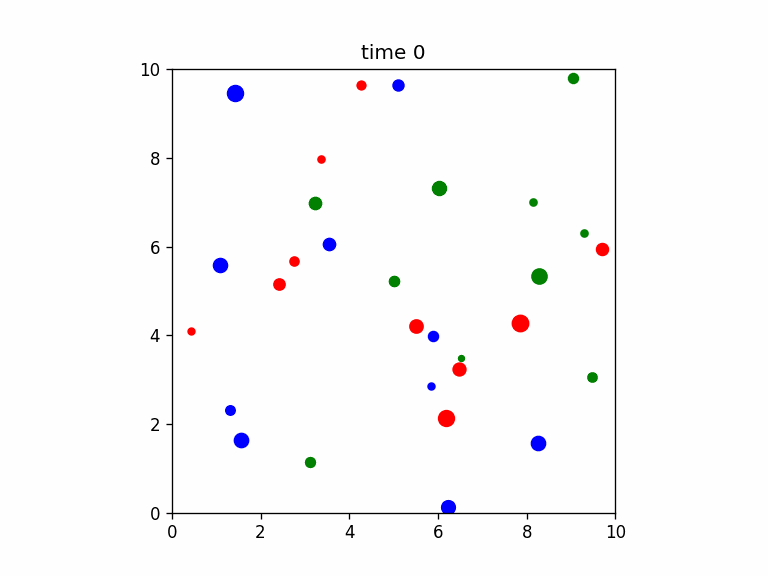

In [81]:
fps = 20  # Frames per second
plot_particles(total_time, env_size, history, filename='multi_species_diffusion.gif', fps=fps)

# Part 2
Using built in matplotlib animation. Not recommended for modularity

In [1]:
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML

def run_diffusion_simulation(n_particles, total_time, env_size, fps=20):
    """
    Run a particle diffusion simulation with uniform diffusion rate, 
    adjusted aspect ratio, and boundaries, then save as a GIF.
    """
    fig, ax = plt.subplots()
    
    # Set the limits and aspect based on env_size
    ax.set_xlim(*env_size[0])
    ax.set_ylim(*env_size[1])
    ax.set_aspect('equal')
    
    particles, = ax.plot([], [], 'bo')
    positions = np.zeros((n_particles, 2))  # Initialize positions at the center
    
    def init():
        particles.set_data([], [])
        return particles,
    
    def update_positions(frame):
        dx = np.random.normal(0, 0.1, n_particles)
        dy = np.random.normal(0, 0.1, n_particles)
        
        # Update positions with boundary checks
        new_x_positions = positions[:, 0] + dx
        new_y_positions = positions[:, 1] + dy
        
        # Reflect particles at boundaries
        new_x_positions[new_x_positions < env_size[0][0]] = 2*env_size[0][0] - new_x_positions[new_x_positions < env_size[0][0]]
        new_x_positions[new_x_positions > env_size[0][1]] = 2*env_size[0][1] - new_x_positions[new_x_positions > env_size[0][1]]
        
        new_y_positions[new_y_positions < env_size[1][0]] = 2*env_size[1][0] - new_y_positions[new_y_positions < env_size[1][0]]
        new_y_positions[new_y_positions > env_size[1][1]] = 2*env_size[1][1] - new_y_positions[new_y_positions > env_size[1][1]]
        
        positions[:, 0] = new_x_positions
        positions[:, 1] = new_y_positions
        
        particles.set_data(positions[:, 0], positions[:, 1])
        return particles,
    
    ani = FuncAnimation(fig, update_positions, frames=total_time, init_func=init, blit=True)
    ani.save('particle_diffusion.gif', writer='pillow', fps=fps)
    
    # Close the plot to prevent it from displaying immediately
    plt.close(fig)
    
    # Display the GIF directly in the notebook
    return HTML('<img src="particle_diffusion.gif" />')

In [2]:
# Call the function with desired parameters
run_diffusion_simulation(
    n_particles=100, 
    total_time=200, 
    env_size=((-6, 6), (-2, 4)), 
    fps=20
)

## multiple species

In [3]:
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML

def run_diffusion_simulation(n_particles_per_species, total_time, env_size, diffusion_rates, fps=20):
    """
    Run a particle diffusion simulation for multiple species with different diffusion rates.
    
    Parameters:
    - n_particles_per_species: List of numbers of particles for each species.
    - total_time: Total time (frames) of the simulation.
    - env_size: Tuple indicating the xlim and ylim of the environment, as ((xmin, xmax), (ymin, ymax)).
    - diffusion_rates: List of diffusion rates for each species.
    - fps: Frames per second for the output GIF.
    """
    fig, ax = plt.subplots()
    
    ax.set_xlim(*env_size[0])
    ax.set_ylim(*env_size[1])
    ax.set_aspect('equal')
    
    # Assuming n_particles_per_species and diffusion_rates are lists of equal length
    total_particles = sum(n_particles_per_species)
    positions = np.zeros((total_particles, 2))  # Initialize positions
    species_colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Extend as needed
    
    particles = [ax.plot([], [], marker='o', ls='', color=species_colors[i % len(species_colors)])[0] for i, _ in enumerate(n_particles_per_species)]
    
    def init():
        for particle in particles:
            particle.set_data([], [])
        return particles

    def update_positions(frame):
        idx = 0
        for species_idx, (n_particles, diffusion_rate) in enumerate(zip(n_particles_per_species, diffusion_rates)):
            dx = np.random.normal(0, diffusion_rate, n_particles)
            dy = np.random.normal(0, diffusion_rate, n_particles)
            
            new_x_positions = positions[idx:idx+n_particles, 0] + dx
            new_y_positions = positions[idx:idx+n_particles, 1] + dy
            
            # Boundary checks
            new_x_positions[new_x_positions < env_size[0][0]] = 2*env_size[0][0] - new_x_positions[new_x_positions < env_size[0][0]]
            new_x_positions[new_x_positions > env_size[0][1]] = 2*env_size[0][1] - new_x_positions[new_x_positions > env_size[0][1]]
            new_y_positions[new_y_positions < env_size[1][0]] = 2*env_size[1][0] - new_y_positions[new_y_positions < env_size[1][0]]
            new_y_positions[new_y_positions > env_size[1][1]] = 2*env_size[1][1] - new_y_positions[new_y_positions > env_size[1][1]]
            
            positions[idx:idx+n_particles, 0] = new_x_positions
            positions[idx:idx+n_particles, 1] = new_y_positions
            
            particles[species_idx].set_data(new_x_positions, new_y_positions)
            idx += n_particles
        
        return particles
    
    ani = FuncAnimation(fig, update_positions, frames=total_time, init_func=init, blit=True)
    ani.save('multi_species_diffusion.gif', writer='pillow', fps=fps)
    plt.close(fig)
    
    return HTML(f'<img src="multi_species_diffusion.gif" />')

In [4]:
# Example usage
run_diffusion_simulation(
    n_particles_per_species=[50, 70, 30, 20, 10], 
    total_time=200, 
    env_size=((-6, 6), (-4, 4)), 
    diffusion_rates=[0.1, 0.05, 0.2, 0.8, 0.01],  # Different diffusion rates for each species
    fps=20
)

## reactions

In [5]:
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML

def run_diffusion_simulation_with_reactions(n_particles_per_species, total_time, env_size, diffusion_rates, stoichiometric_matrix, reaction_propensities, fps=20):
    """
    Run a particle diffusion simulation for multiple species with different diffusion rates and reactions.
    
    Parameters:
    - n_particles_per_species: List of numbers of particles for each species.
    - total_time: Total time (frames) of the simulation.
    - env_size: Tuple indicating the xlim and ylim of the environment, as ((xmin, xmax), (ymin, ymax)).
    - diffusion_rates: List of diffusion rates for each species.
    - stoichiometric_matrix: Matrix indicating the changes in species counts for each reaction.
    - reaction_propensities: List of propensities for each reaction.
    - fps: Frames per second for the output GIF.
    """
    fig, ax = plt.subplots()
    ax.set_xlim(*env_size[0])
    ax.set_ylim(*env_size[1])
    ax.set_aspect('equal')
    
    total_particles = sum(n_particles_per_species)
    positions = np.zeros((total_particles, 2))  # Initialize positions
    
    particles = [ax.plot([], [], 'o', markersize=5)[0] for _ in range(len(n_particles_per_species))]
    
    def init():
        for particle in particles:
            particle.set_data([], [])
        return particles
    
    def update_positions(frame):
        nonlocal n_particles_per_species
        idx = 0
        for species_idx, (n_particles, diffusion_rate) in enumerate(zip(n_particles_per_species, diffusion_rates)):
            dx = np.random.normal(0, diffusion_rate, n_particles)
            dy = np.random.normal(0, diffusion_rate, n_particles)
            
            positions[idx:idx+n_particles, 0] += dx
            positions[idx:idx+n_particles, 1] += dy
            
            # Enforce boundaries
            positions[idx:idx+n_particles] = np.clip(positions[idx:idx+n_particles], env_size[0][0], env_size[1][1])
            
            particles[species_idx].set_data(positions[idx:idx+n_particles, 0], positions[idx:idx+n_particles, 1])
            idx += n_particles
        
        # Perform reactions based on propensities
        for reaction_idx, propensity in enumerate(reaction_propensities):
            if np.random.rand() < propensity:
                # Update species counts according to the stoichiometric matrix
                n_particles_per_species = [max(0, count + change) for count, change in zip(n_particles_per_species, stoichiometric_matrix[reaction_idx])]
                
        return particles
    
    ani = FuncAnimation(fig, update_positions, frames=total_time, init_func=init, blit=True)
    ani.save('reaction_diffusion_simulation.gif', writer='pillow', fps=fps)
    plt.close(fig)
    
    return HTML(f'<img src="reaction_diffusion_simulation.gif" />')

In [6]:
# Example parameters
n_particles_per_species = [100, 20]  # Initial counts for two species
diffusion_rates = [0.2, 0.02]  # Different diffusion rates for each species
stoichiometric_matrix = [[-1, 1]]  # Example reaction: 1st species converts into 2nd species
reaction_propensities = [0.2]  # Likelihood of the reaction occurring at each timestep

run_diffusion_simulation_with_reactions(
    n_particles_per_species, 
    200, 
    ((-6, 6), (-4, 4)), 
    diffusion_rates, 
    stoichiometric_matrix, 
    reaction_propensities, 
    20
)


In [7]:
def run_diffusion_simulation_with_distance_reactions(
    n_particles, 
    diffusion_rates, 
    total_time, 
    env_size, 
    reaction_distance, 
    fps=20
):
    """
    Run a particle diffusion simulation with A + B -> C reactions based on distance and correct boundary handling.
    """
    fig, ax = plt.subplots()
    ax.set_xlim(env_size[0])
    ax.set_ylim(env_size[1])
    ax.set_aspect('equal')

    positions = {
        'A': np.random.uniform(low=[env_size[0][0], env_size[1][0]], high=[env_size[0][1], env_size[1][1]], size=(n_particles['A'], 2)),
        'B': np.random.uniform(low=[env_size[0][0], env_size[1][0]], high=[env_size[0][1], env_size[1][1]], size=(n_particles['B'], 2)),
        'C': np.random.uniform(low=[env_size[0][0], env_size[1][0]], high=[env_size[0][1], env_size[1][1]], size=(n_particles['C'], 2)),
    }

    colors = {'A': 'bo', 'B': 'go', 'C': 'ro'}
    particles_plot = {species: ax.plot([], [], colors[species], markersize=5)[0] for species in 'ABC'}

    def init():
        for plot in particles_plot.values():
            plot.set_data([], [])
        return particles_plot.values()

    def update(frame):
        # Update positions for each species
        for species, rate in diffusion_rates.items():
            steps = np.random.normal(0, rate, positions[species].shape)
            positions[species] += steps
            # Enforce boundaries for x and y separately
            positions[species][:, 0] = np.clip(positions[species][:, 0], env_size[0][0], env_size[0][1])
            positions[species][:, 1] = np.clip(positions[species][:, 1], env_size[1][0], env_size[1][1])
            particles_plot[species].set_data(positions[species][:, 0], positions[species][:, 1])

        # Reactions based on distance (simplified for demonstration)
        if frame % 10 == 0:  # Check for reactions every 10 frames to simplify
            for i, pos_a in enumerate(positions['A']):
                distances = np.linalg.norm(positions['B'] - pos_a, axis=1)
                reactants = np.where(distances < reaction_distance)[0]
                if len(reactants) > 0:
                    pos_b = positions['B'][reactants[0]]
                    new_pos_c = (pos_a + pos_b) / 2
                    positions['C'] = np.vstack([positions['C'], new_pos_c])
                    positions['A'] = np.delete(positions['A'], i, axis=0)
                    positions['B'] = np.delete(positions['B'], reactants[0], axis=0)
                    break  # Simplification: only one reaction per check

        return particles_plot.values()

    ani = FuncAnimation(fig, update, frames=total_time, init_func=init, blit=True, repeat=False)
    ani.save('corrected_distance_reaction_diffusion.gif', writer='pillow', fps=fps)
    plt.close(fig)

    return HTML(f'<img src="corrected_distance_reaction_diffusion.gif" />')


In [8]:
# Define initial conditions and parameters for the simulation
n_particles = {'A': 100, 'B': 100, 'C': 0}  # Initial number of particles for A, B, and C
diffusion_rates = {'A': 0.05, 'B': 0.01, 'C': 0.1}  # Diffusion rates for each species
env_size = ((-6, 6), (-4, 4))  # Environment size as ((xmin, xmax), (ymin, ymax))
reaction_distance = 0.5  # Distance threshold for A + B -> C reaction
total_time = 200  # Total time (frames) of the simulation
fps = 20  # Frames per second for the output GIF

# Run the simulation
run_diffusion_simulation_with_distance_reactions(
    n_particles=n_particles, 
    diffusion_rates=diffusion_rates, 
    total_time=total_time, 
    env_size=env_size, 
    reaction_distance=reaction_distance, 
    fps=fps
)

## Generalized particle reactions

In [9]:
def run_simulation_with_stoichiometry(n_particles, diffusion_rates, stoichiometry, propensities, total_time, env_size, reaction_distance, fps=20):
    fig, ax = plt.subplots()
    ax.set_xlim(*env_size[0])
    ax.set_ylim(*env_size[1])
    ax.set_aspect('equal')

    species_list = list(n_particles.keys())  # List of species
    n_species = len(species_list)
    
    # Assign colors from a colormap
    cmap = plt.get_cmap('Set1')
    species_colors = {species: cmap(i / n_species) for i, species in enumerate(species_list)}

    # Initialize particle positions for all species
    positions = {species: np.random.uniform(low=[env_size[0][0], env_size[1][0]], high=[env_size[0][1], env_size[1][1]], size=(count, 2)) for species, count in n_particles.items()}

    # Create a plot object for each species
    particles_plot = {species: ax.plot(positions[species][:, 0], positions[species][:, 1], 'o', markersize=5, color=species_colors[species])[0] for species in n_particles}

    # Add legend
    for species, color in species_colors.items():
        ax.plot([], [], 'o', color=color, label=species)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    def update(frame):
        # Update positions based on diffusion
        for species, rate in diffusion_rates.items():
            steps = np.random.normal(0, rate, positions[species].shape)
            positions[species] += steps
            # Enforce boundaries for x and y separately
            positions[species][:, 0] = np.clip(positions[species][:, 0], env_size[0][0], env_size[0][1])
            positions[species][:, 1] = np.clip(positions[species][:, 1], env_size[1][0], env_size[1][1])
            particles_plot[species].set_data(positions[species][:, 0], positions[species][:, 1])

        # Handle reactions based on stoichiometry and propensities
        for reaction_idx, (reactant_indices, product_index) in enumerate(stoichiometry):
            if np.random.rand() < propensities[reaction_idx]:
                # Simplified reaction logic for illustrative purposes
                # Assumes single reactant -> single product for demonstration
                reactant_species = species_list[reactant_indices[0]]
                product_species = species_list[product_index]
                reactant_positions = positions[reactant_species]

                # Convert a fraction of reactants to products
                n_react = len(reactant_positions)
                n_convert = np.random.binomial(n_react, propensities[reaction_idx])  # Number of reactants to convert

                if n_convert > 0:
                    new_product_positions = reactant_positions[:n_convert]
                    positions[product_species] = np.vstack([positions[product_species], new_product_positions])
                    positions[reactant_species] = positions[reactant_species][n_convert:]

        return [particles_plot[species] for species in species_list]

    ani = FuncAnimation(fig, update, frames=range(total_time), blit=True)
    plt.tight_layout(rect=[0, 0, 0.8, 1])
    ani.save('stoichiometry_reaction_diffusion.gif', writer='pillow', fps=fps)
    plt.close(fig)

    return HTML(f'<img src="stoichiometry_reaction_diffusion.gif" />')


In [10]:
# Define initial conditions and parameters
n_particles = {'A': 60, 'B': 100, 'C': 0, 'D': 0}  # Initial number of particles
diffusion_rates = {'A': 0.05, 'B': 0.05, 'C': 0.2, 'D': 0.1}  # Diffusion rates

# Stoichiometry: List of tuples with (reactants, product) by their indices in species_list
# Assuming species_list is ['A', 'B', 'C', 'D']
stoichiometry = [((0, 1), 2), ((1, 2), 3)]  # Corresponds to A+B->C and B+C->D

propensities = [0.05, 0.01]  # Propensity for each reaction

env_size = ((-6, 6), (-4, 4))  # Environment size
reaction_distance = 0.4  # Distance within which reactions can occur
total_time = 400  # Total simulation time (frames)
fps = 20  # Frames per second for the GIF

# Run the simulation
run_simulation_with_stoichiometry(
    n_particles=n_particles, 
    diffusion_rates=diffusion_rates, 
    stoichiometry=stoichiometry, 
    propensities=propensities, 
    total_time=total_time, 
    env_size=env_size, 
    reaction_distance=reaction_distance,
    fps=fps
)


## with stoichiometry

In [11]:
def run_simulation_with_stoichiometry(
    n_particles, 
    diffusion_rates, 
    stoichiometry, 
    propensities, 
    total_time, 
    env_size, 
    reaction_distance, 
    fps=20
):
    fig, ax = plt.subplots()
    ax.set_xlim(*env_size[0])
    ax.set_ylim(*env_size[1])
    ax.set_aspect('equal')

    species_list = list(n_particles.keys())
    n_species = len(species_list)
    
    # Assign colors from a colormap dynamically
    cmap = plt.get_cmap('Set1')
    species_colors = {species: cmap(i) for i, species in enumerate(species_list)}

    positions = {species: np.random.uniform(low=[env_size[0][0], env_size[1][0]], high=[env_size[0][1], env_size[1][1]], size=(count, 2))
                 for species, count in n_particles.items()}
    particles_plot = {species: ax.plot(pos[:, 0], pos[:, 1], 'o', markersize=5, color=species_colors[species])[0]
                      for species, pos in positions.items()}

    for species, color in species_colors.items():
        ax.plot([], [], 'o', color=color, label=species)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    def update(frame):
        for species, rate in diffusion_rates.items():
            steps = np.random.normal(0, rate, positions[species].shape)
            positions[species] += steps
            positions[species][:, 0] = np.clip(positions[species][:, 0], env_size[0][0], env_size[0][1])
            positions[species][:, 1] = np.clip(positions[species][:, 1], env_size[1][0], env_size[1][1])
            particles_plot[species].set_data(positions[species][:, 0], positions[species][:, 1])

        # New reaction handling based on stoichiometry and propensities
        for reaction_idx, stoich in enumerate(stoichiometry):
            if np.random.rand() < propensities[reaction_idx]:
                reactant_species = [species_list[i] for i in range(n_species) if stoich[i] < 0]
                product_species = [species_list[i] for i in range(n_species) if stoich[i] > 0]
                
                # For simplicity, this example assumes uniform reaction distance for all species
                # and that a single reaction happens per frame for this reaction type
                for r_species in reactant_species:
                    for p_species in product_species:
                        # Identify pairs within reaction distance
                        for pos in positions[r_species]:
                            distances = np.linalg.norm(positions[p_species] - pos, axis=1)
                            close_indices = np.where(distances < reaction_distance)[0]
                            if len(close_indices) > 0:
                                # Process reaction: consume reactants, generate products
                                reactant_reduction = np.min([-stoich[species_list.index(r_species)] for r_species in reactant_species])
                                positions[p_species] = np.vstack([positions[p_species], positions[r_species][:1] * stoich[species_list.index(p_species)]])
                                positions[r_species] = positions[r_species][reactant_reduction:]

        return [particles_plot[species] for species in species_list]

    ani = FuncAnimation(fig, update, frames=range(total_time), blit=True)
    plt.tight_layout(rect=[0, 0, 0.8, 1])
    ani.save('stoichiometry_reaction_diffusion_updated.gif', writer='pillow', fps=fps)
    plt.close(fig)

    return HTML(f'<img src="stoichiometry_reaction_diffusion_updated.gif" />')


In [12]:
# Redefine stoichiometry and propensities for a matrix-based representation
stoichiometry = np.array([
    [-1, -1, 1, 0],  # Reaction 1: A + B -> C
    [0, -1, -1, 1]   # Reaction 2: B + C -> D
])

propensities = [0.5, 0.01]  # Propensity for each reaction

# # Assume species_list is ['A', 'B', 'C', 'D']
# species_list = ['A', 'B', 'C', 'D']

# Initial conditions and parameters
n_particles = {'A': 60, 'B': 100, 'C': 0, 'D': 0}  # Initial number of particles
diffusion_rates = {'A': 0.05, 'B': 0.05, 'C': 0.2, 'D': 0.1}  # Diffusion rates

env_size = ((-6, 6), (-4, 4))  # Environment size
reaction_distance = 0.4  # Distance within which reactions can occur
total_time = 400  # Total simulation time (frames)
fps = 20  # Frames per second for the GIF

# simulate
run_simulation_with_stoichiometry(
    n_particles=n_particles, 
    diffusion_rates=diffusion_rates, 
    stoichiometry=stoichiometry, 
    propensities=propensities, 
    total_time=total_time, 
    env_size=env_size, 
    reaction_distance=reaction_distance,
    fps=fps
)
